In [ ]:
%reset -f

## Construire un modèle

### Sur les notations

Un modèle est une fonction paramétrique, qui prend donc deux argument:
* un paramètre noté `param` ou `params` ou `Θ`
* Une entrée (input). Noté `inp`, `x`, `xy` `X` etc.

Perso:
* Dans un contexte de data j'appelle mon modèle simplement `model`, `model_apply`
* Dans un contexte de calcul scientifique (notamment pour les Pinns), je le note `U_of_Θ_inp` ou  `U_of_Θ_x` ou `U_of_Θ_xy` etc.


Je rajoute des `V` pour les version vectoriées par exemple `U_of_Θ_inpV` (et ce n'est que les `inpV` qui sont vectorisées).


Le paramètre est le premier argument, car le plus souvent on calcule de gradient par rapport au paramètre, et que la fonction `jax.grad` a comme défaut `jax.grad(fn,argnums=0)`

### Définition des `params` d'un modèle

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import matplotlib.pyplot as plt

En Jax il y a plein de façon de créer des modèles. La plus simple était d'utiliser le design `model_init, model_apply`:

In [ ]:
#j'utilise le suffix "fnm" pour "function_maker"
def model_fnm(layer_widths):

    def model_init(rkey):
        params = []
        for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
            rk,rkey=jr.split(rkey)
            params.append(
                {"weight":jr.normal(rk,shape=(n_in, n_out))*jnp.sqrt(2/n_in),
                "bias":jnp.zeros([n_out])})
        return params

    def model_apply(params, inp):
        *hidden, last = params
        for layer in hidden:
            inp = jax.nn.relu(inp @ layer['weight'] + layer['bias'])
        return inp @ last['weight'] + last['bias']

    return model_init,model_apply

model_init,model_apply=model_fnm([2,4,8,1])

In [ ]:
params=model_init(jr.key(0))
for tensor in jax.tree.leaves(params):
    print(tensor.shape)

***A vous:*** Faites un graphique qui illustre cette architecture. As-t-on mis une fonction d'activation finale ?

Notez au passage l'utilisation du zip:

In [ ]:
l1=["a","b","c"]
l2=[1,2,3]
for a,b in zip(l1,l2):
    print(a,b)

In [ ]:
layer_widths=[1,3,5,7]
for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    print(n_in,n_out)

### Récréation: dessinons un petit modèle

Voici un réseau plus modeste

***A vous:*** Que symbolisent les fèches noires ($1\heartsuit$)? Combien ce réseau a de paramètre ($1\heartsuit$)?

In [ ]:
nb_input=16
nb_hidden1=8
nb_hidden2=4
input_points= [(1,i) for i in range(nb_input)]
hidden1_points=[(2,2*i+0.5) for i in range(nb_hidden1)]
hidden2_points=[(3,4*i+1) for i in range(nb_hidden2)]


for x,y in input_points:
  for a,b in hidden1_points:
    plt.plot([x,a],[y,b])


for a,b in hidden1_points:
  plt.plot([1.1,a],[16,b],"k")
  for x,y in hidden2_points:
    plt.plot([x,a],[y,b])


for x,y in hidden2_points:
  plt.plot([2.1,x],[16,y],"k")
  plt.plot([x,4],[y,8])


plt.plot([3.1,4],[16,8],"k");

### Polyvalence

L'opérateur `@` est polyvalent:

    A@B = jnp.dot(A,B)

signifie que, quand B a au moins 2 indices:

    C[...,j] = sum_i A[...,i]B[...i,j]


⇑ La sommation se fait sur le dernier indice de A et l'avant dernier de B




Exemples:

In [ ]:
A=jnp.ones([3])
B=jnp.ones([3,4])
#C[j]=sum_i A[i]B[i,j]
C=A@B
C.shape

In [ ]:
A=jnp.ones([7,3])
B=jnp.ones([3,4])
#C[a,j]=sum_i A[a,i]B[i,j]
C=A@B
C.shape

In [ ]:
A=jnp.ones([1,2,3,6])
B=jnp.ones([1,2,6,5])
C=A@B
C.shape

Remarque si  B a un seul indice alors le comportement change un peu:

    C = A@B

signifie

    C[...] = sum_i A[...,i]B[i]

Par conséquent, model_apply est polyvalent, est basé sur des `@` où le membre de gauche peut être un input simple:


    inp  @     W
    d_in   d_in-d_out


le résultat est alors un vecteur de dimention `d_out`.

Ou bien le membre de gauche peut être un input vectorisé (`b` étant le `batch_size`):

      inp   @     W
    b-d_in    d_in-d_out

le résultat est alors un batch de vecteur de shape `(b,d_out)`




Testons avec un simple input:

In [ ]:
model_init,model_apply=model_fnm([2,4,8,5])
params=model_init(jr.key(0))

In [ ]:
inp=jnp.ones([2])
model_apply(params,inp).shape

ou un input vectorisé:

In [ ]:
inpV=jnp.ones([7,2]) #b=7
out_predV=model_apply(params,inpV)
out_predV.shape

Cependant on préférera prendre l'habitude de vectoriser le modèle avec vmap pour plus de clarté (et car cela sera obligatoire pour des modèles plus complexes qui ne seront pas définis avec de simples `@`).

In [ ]:
model_applyV=vmap(model_apply,in_axes=(None,0))
out_predV_bis=model_applyV(params,inpV)
out_predV_bis.shape

In [ ]:
assert jnp.allclose(out_predV,out_predV_bis)

Remarque: Dans les librairies comme torch ou tensorflow, on construit uniquement les versions vectorisées des modèles càd qu'on prévoit toujours un indice de batch en premier.


### Une fonction pour l'entrainement

In [ ]:

def train(initial_param,model_applyV,inpV,outV,lr,n_step):


    def loss_fn(param, inpV, outV):
        #must return a scalar
        return jnp.mean((model_applyV(param, inpV) - outV) ** 2)


    losses=[]
    def update(param, inpV, outV):
        loss,grads = jax.value_and_grad(loss_fn)(param, inpV, outV)
        # `grads` is a pytree with the same structure as `param`.

        param=jax.tree.map(
            lambda p, g: p - lr * g, param, grads
        )
        return loss,param


    param=initial_param

    for _ in range(n_step):
        loss,param=update(param,inpV,outV)
        losses.append(loss)

    return losses,param


### Données linéaire 1D



On veut créer des données disposées selon une droite, mais avec du bruit

In [ ]:
TRUE_W = 3.0 #coef directeur de la droite
TRUE_b = 2.0 #coef constant
NUM_EXAMPLES = 1000 #nombre de point

In [ ]:
def inpV_outV_fn(rkey):
    rk1,rk2=jr.split(rkey)
    inputs  = jr.normal(rk1,shape=(NUM_EXAMPLES,))
    noise   = jr.normal(rk2,shape=(NUM_EXAMPLES,))
    outputs = inputs * TRUE_W + TRUE_b + noise
    return inputs[:,None],outputs[:,None]

In [ ]:
inpV,outV=inpV_outV_fn(jr.key(0))
inpV.shape,outV.shape

On a pris soit d'ajouter une dimension avec `[:,None]` pour respecteur le format des données classiques: `(batch_size,dim)`

In [ ]:
plt.scatter(inpV, outV, color='b',marker='.');

In [ ]:
model_init,model_apply=model_fnm([1,1])
param=model_init(jr.key(0))

for p in jax.tree.leaves(param):
    print(p.shape)

In [ ]:
model_applyV=vmap(model_apply,[None,0])

In [ ]:
losses,params_trained=train(param,model_applyV,inpV,outV,0.1,10)

In [ ]:
fig,ax=plt.subplots()
ax.plot(losses);

***A vous:*** On trouve que l'entrainement n'est pas fini. Comment est-ce que vous pouriez le poursuivre sans pour autant repartir de zéro ?

In [ ]:
losses,params_trained=train(...


In [ ]:
fig,ax=plt.subplots()
ax.plot(losses);

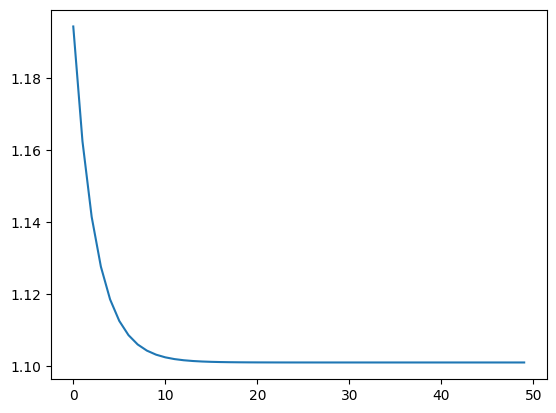

In [ ]:
#--- To keep following outputs, do not run this cell! ---

In [ ]:
fig,ax=plt.subplots()
ax.scatter(inpV, outV, color='b',marker='.')

inpV_regulars=jnp.linspace(inpV.min(),inpV.max(),10)[:,None]
ax.plot(inpV_regulars,model_apply(params_trained,inpV_regulars),color='r');

***A vous:*** Retracez la droite rouge sans utiliser la fonction `model_apply`, mais uniquement à partir des valeurs dans `params_trained`.

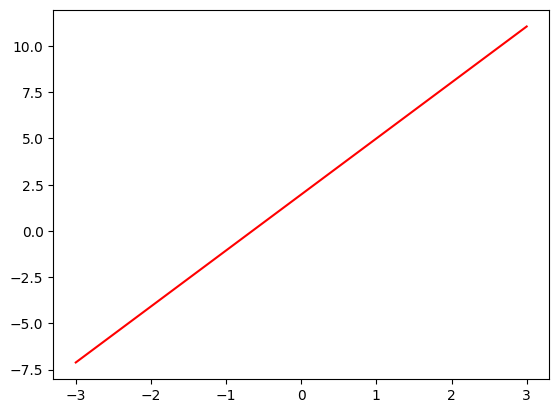

In [ ]:
#--- To keep following outputs, do not run this cell! ---

### Données plus complexes

In [ ]:
def inpV_outV_fn(rkey):
    rk1,rk2=jr.split(rkey)
    inputs  = jr.normal(rk1,shape=(NUM_EXAMPLES,))
    noise   = jr.normal(rk2,shape=(NUM_EXAMPLES,))
    outputs = (inputs * TRUE_W)**2 + TRUE_b + noise
    return inputs[:,None],outputs[:,None]

In [ ]:
inpV,outV=inpV_outV_fn(jr.key(0))
inpV.shape,outV.shape

On a pris soit d'ajouter une dimension avec `[:,None]` pour respecteur le format des données classiques: `(batch_size,dim)`

In [ ]:
plt.scatter(inpV, outV, color='b',marker='.');

### Défi prog

Faites apprendre ces données à votre modèle